## Stock Market Prediction Using Numerical and Textual Analysis

Objective: Create a hybrid model for stock proce/performance prediction using numerical analysis of news headlines

In [8]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost

In [2]:
pip install textblob

     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
     - -------------------------------------- 30.7/636.8 kB ? eta -:--:--
     ----- --------------------------------- 92.2/636.8 kB 1.3 MB/s eta 0:00:01
     ------- ------------------------------ 122.9/636.8 kB 1.0 MB/s eta 0:00:01
     ----------------- -------------------- 286.7/636.8 kB 1.6 MB/s eta 0:00:01
     ----------------- -------------------- 286.7/636.8 kB 1.6 MB/s eta 0:00:01
     ----------------- -------------------- 286.7/636.8 kB 1.6 MB/s eta 0:00:01
     ----------------------------- -------- 501.8/636.8 kB 1.7 MB/s eta 0:00:01
     -------------------------------------  634.9/636.8 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 636.8/636.8 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.3 MB 3.5 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.3 MB 4.4 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.3 MB 4.6 MB/s eta 0:00:01
   -------------------------- ------------- 0.9/1.3 MB 4.9 MB/s eta 0:00:01
   ------------------------------- -------- 1.0/1.3 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import lightgbm

In [3]:
from textblob import TextBlob

In [5]:
pip install pandas-datareader

     ---------------------------------------- 0.0/109.5 kB ? eta -:--:--
     ----------------------------------- -- 102.4/109.5 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 109.5/109.5 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

In [11]:
# Load the first dataset
columns=['Date','Category','News']
data = pd.read_csv("india-news-headlines.csv",names=columns)

In [13]:
news_data = data

In [14]:
news_data

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [15]:
news_data.drop(0, inplace=True)
news_data.drop('Category', axis = 1, inplace=True)

In [30]:
# Load the second dataset
data_sec = pd.read_csv(r"C:\Users\Rizky_Ade\Documents\File Kuliah\Project\Stock Market Prediction\^BSESN.csv")

In [31]:
data_sec.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


## Common Dataset Exploration

In [20]:
# Check for common information of the first datast
news_data["Date"] = pd.to_datetime(news_data["Date"],format='%Y%m%d')
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 55.7+ MB


In [21]:
# Group the headlines for each day
news_data['News'] = news_data.groupby(['Date']).transform(lambda x : ' '.join(x))

In [23]:
news_data.duplicated()

1          False
2           True
3           True
4           True
5           True
           ...  
3650966     True
3650967     True
3650968     True
3650969     True
3650970     True
Length: 3650970, dtype: bool

In [24]:
news_data = news_data.drop_duplicates()
news_data.reset_index(inplace=True,drop=True)

In [25]:
# Check for any duplicated values
news_data.isnull().sum()

Date    0
News    0
dtype: int64

In [26]:
len(news_data)

7717

In [32]:
data_sec=data_sec[["Date","Open","High","Low","Close","Volume"]]
data_sec.head()

,Date,Open,High,Low,Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0


In [33]:
data_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    252 non-null    object 
 1   Open    250 non-null    float64
 2   High    250 non-null    float64
 3   Low     250 non-null    float64
 4   Close   250 non-null    float64
 5   Volume  250 non-null    float64
dtypes: float64(5), object(1)
memory usage: 11.9+ KB


In [35]:
data_sec["Date"]= pd.to_datetime(data_sec["Date"])
data_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB


In [37]:
data_sec.describe()

,Open,High,Low,Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237375,38071.182859,37422.826992,37745.454117,19134.000000
std,4507.985769,4380.974060,4647.212947,4535.304336,16540.261333
min,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,13125.000000
50%,38489.480469,38750.359375,38234.869140,38425.974610,17000.000000
75%,41179.222656,41376.482422,41023.923828,41135.233399,21075.000000
max,46774.320313,46992.570313,46627.601563,46890.339844,188300.000000


In [38]:
data_sec.isnull()

,Date,Open,High,Low,Close,Volume
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
247,False,False,False,False,False,False
248,False,False,False,False,False,False
249,False,False,False,False,False,False
250,False,False,False,False,False,False


In [39]:
len(data_sec)

252

Text(0, 0.5, 'BSESN')

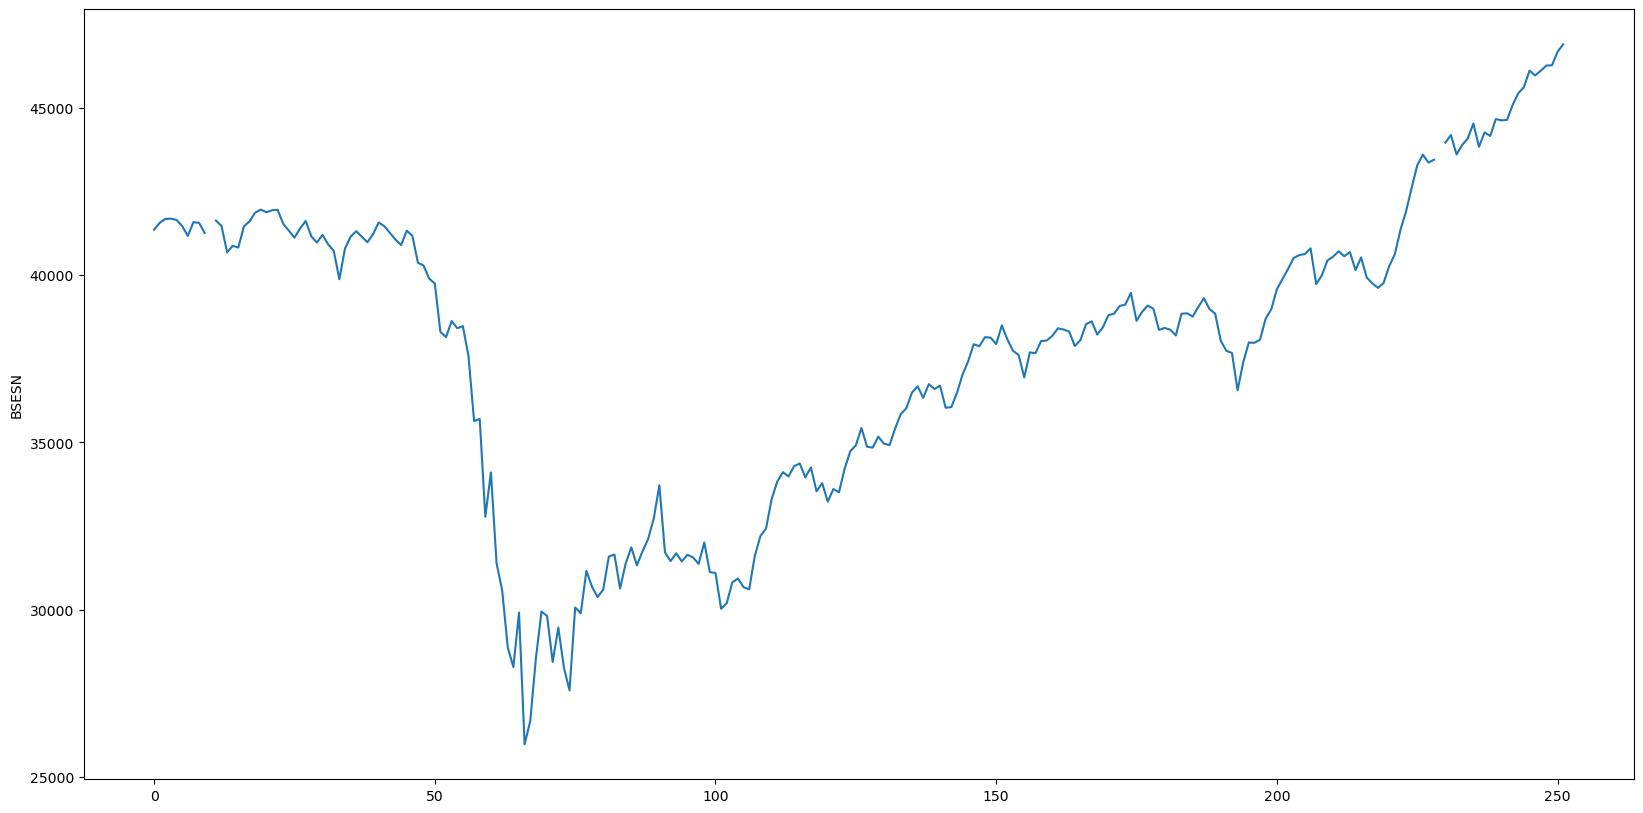

In [40]:
# Figure plot
plt.figure(figsize=(20,10))
data_sec['Close'].plot()
plt.ylabel('BSESN')

In [41]:
#removing unwanted characters from the News
news_data.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
news_data["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

## Historical Analysis

### Plot the Moving Average

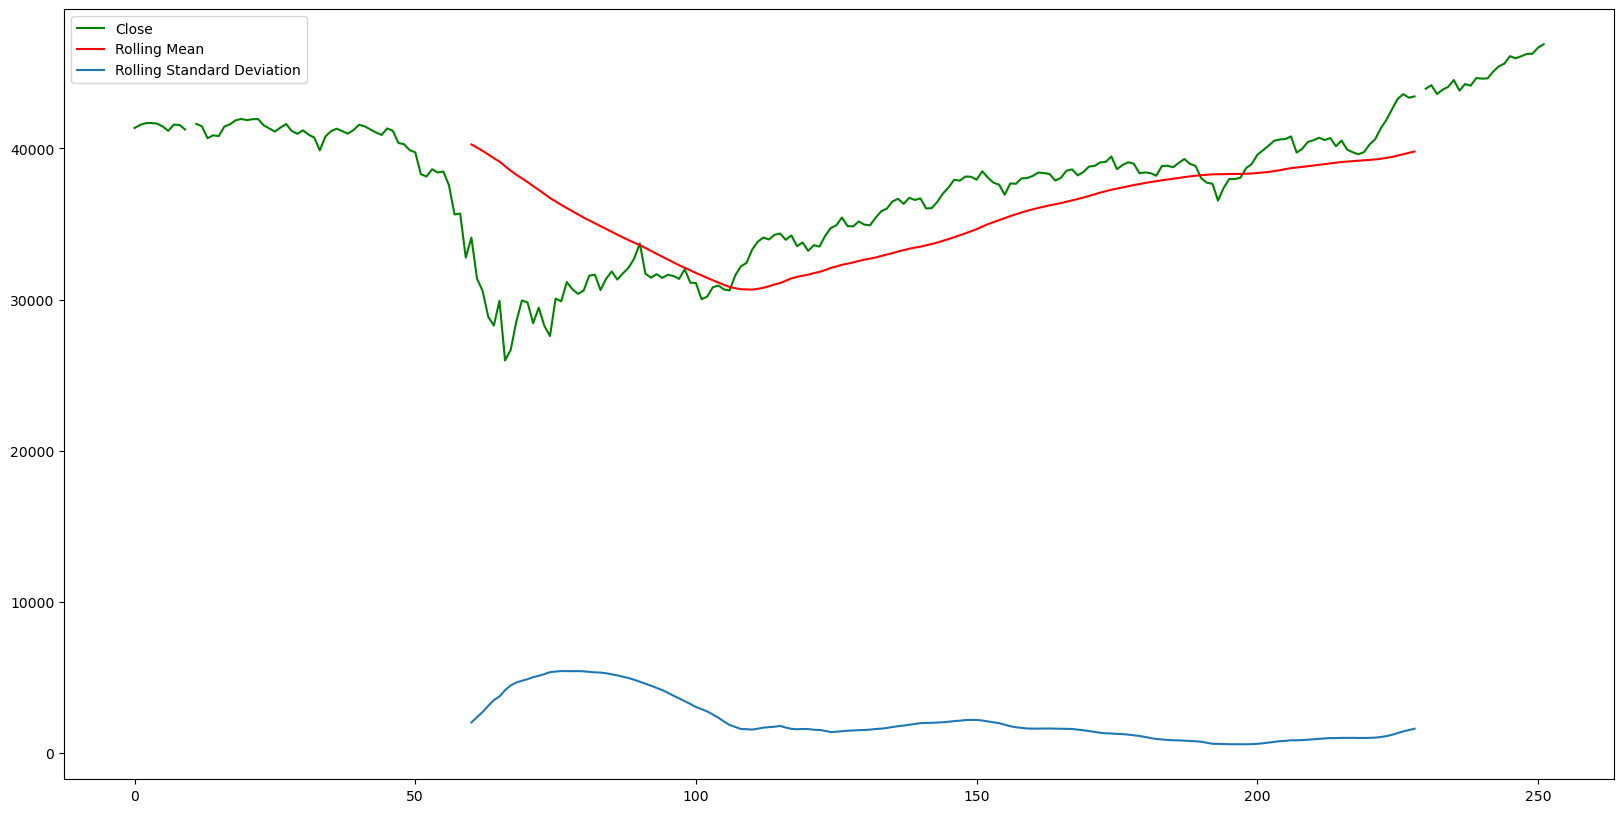

In [42]:
#Plotting moving average
close = data_sec['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
data_sec['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

## Plot the Returns

Text(0.5, 1.0, 'Returns')

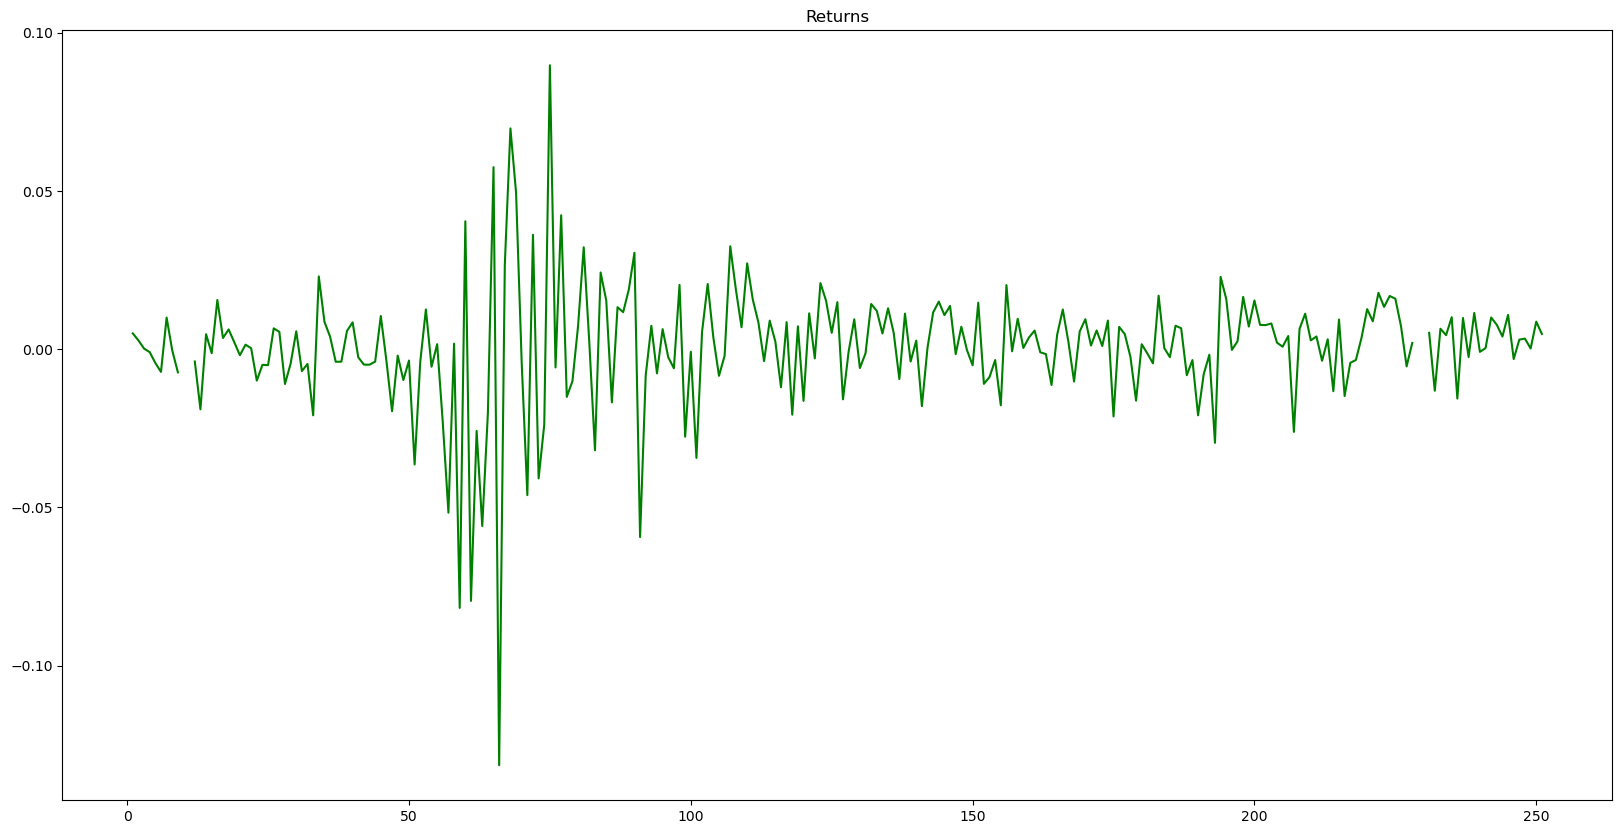

In [43]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [47]:
data_sec[1219:]

,Date,Open,High,Low,Close,Volume


In [45]:
# Train test split
train = data_sec[:1219]
test = data_sec[1219:]

## Rolling mean and Standard Deviation

In [58]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [62]:
#Stationarity test
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)

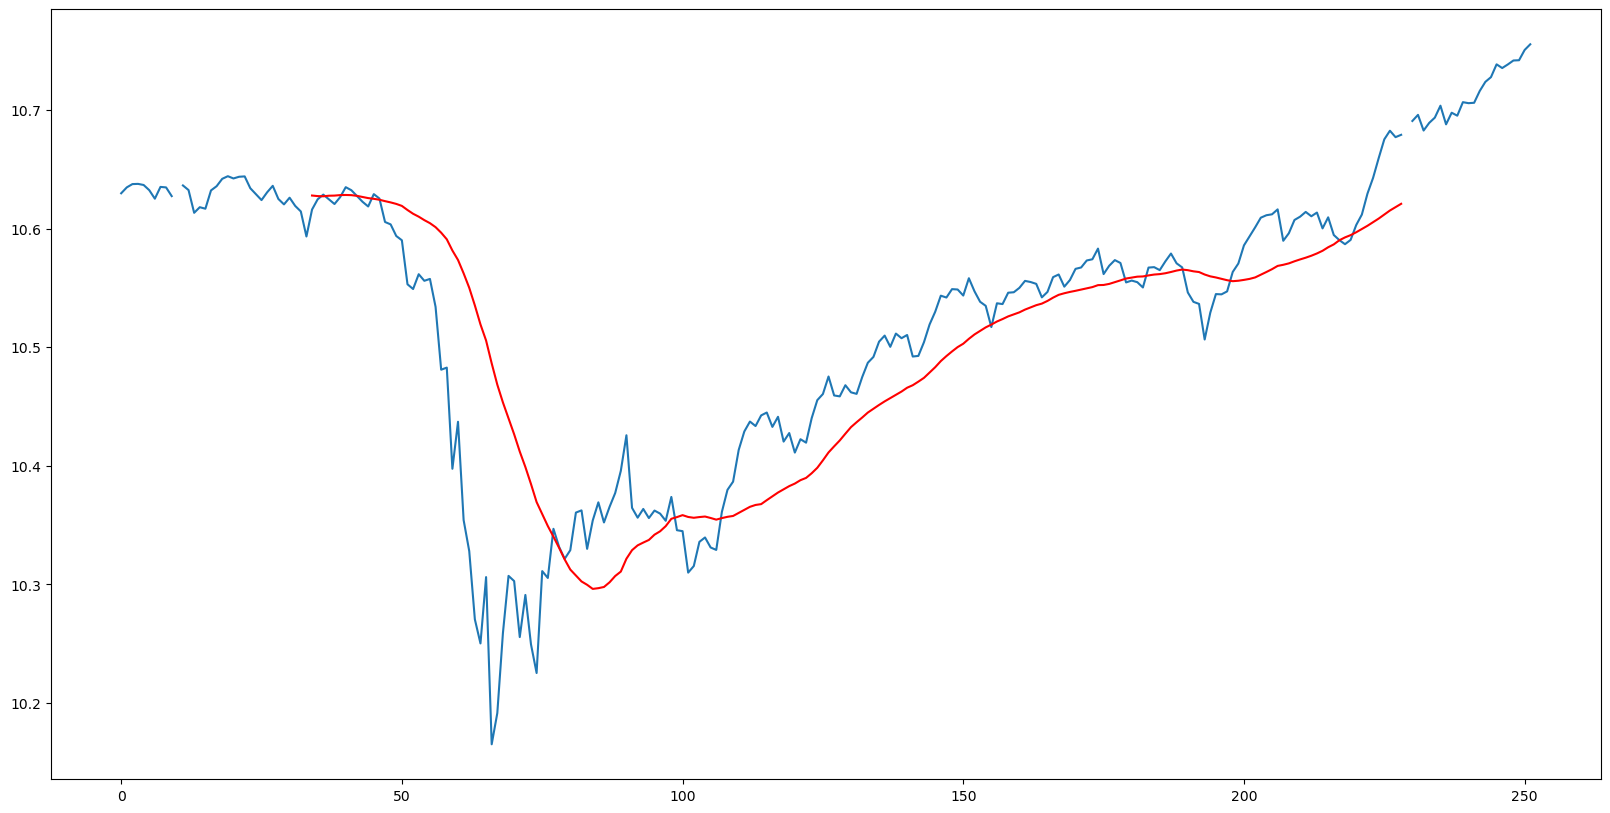

In [51]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (20,10))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

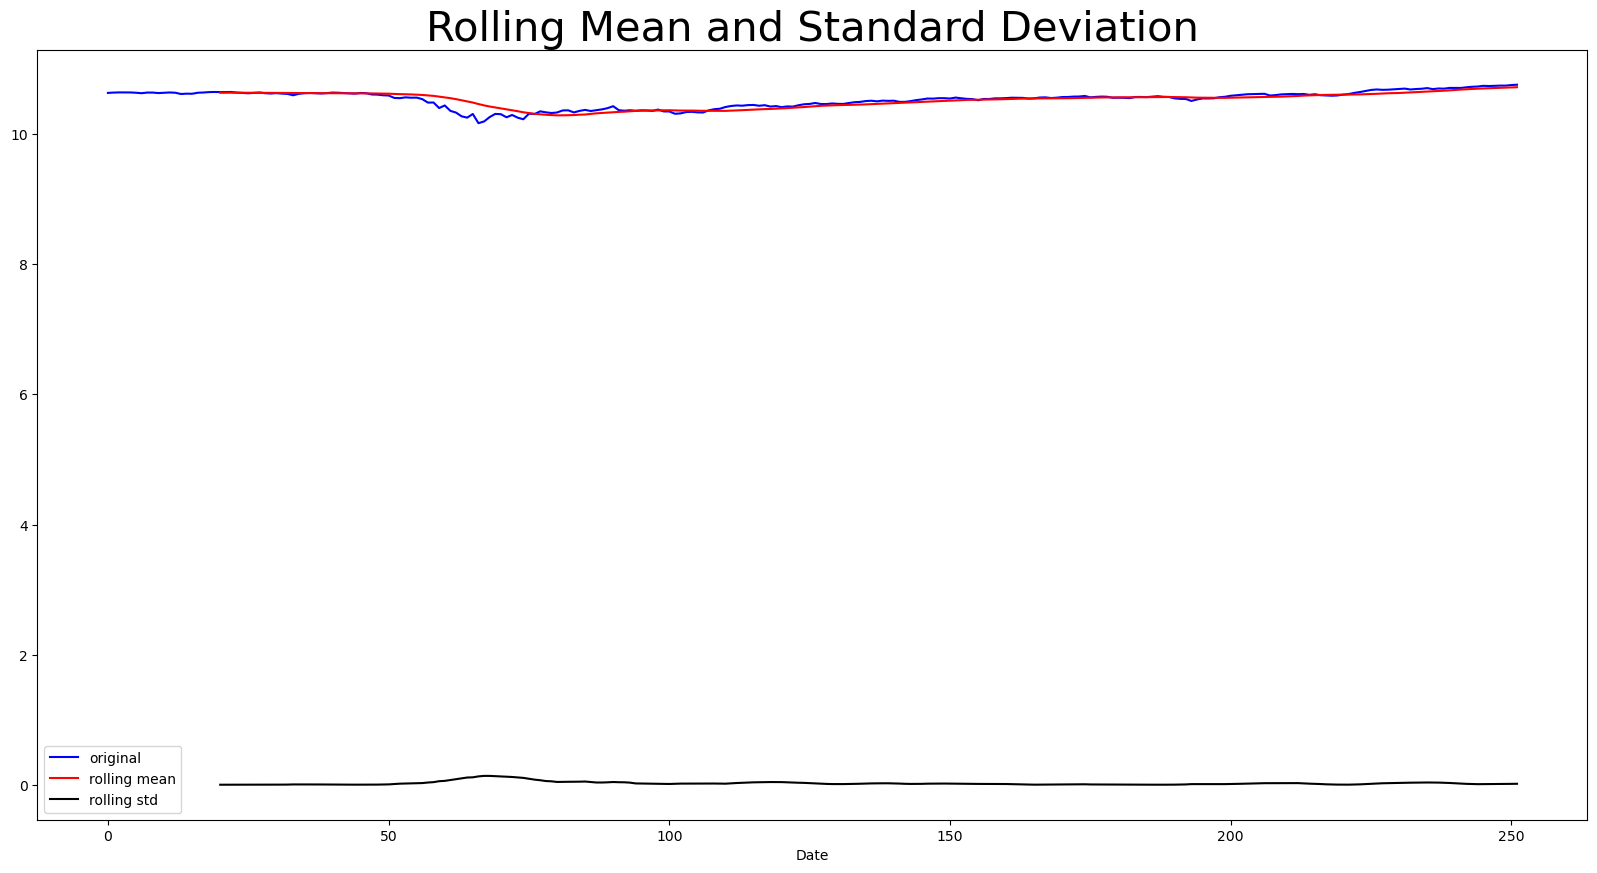

In [76]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

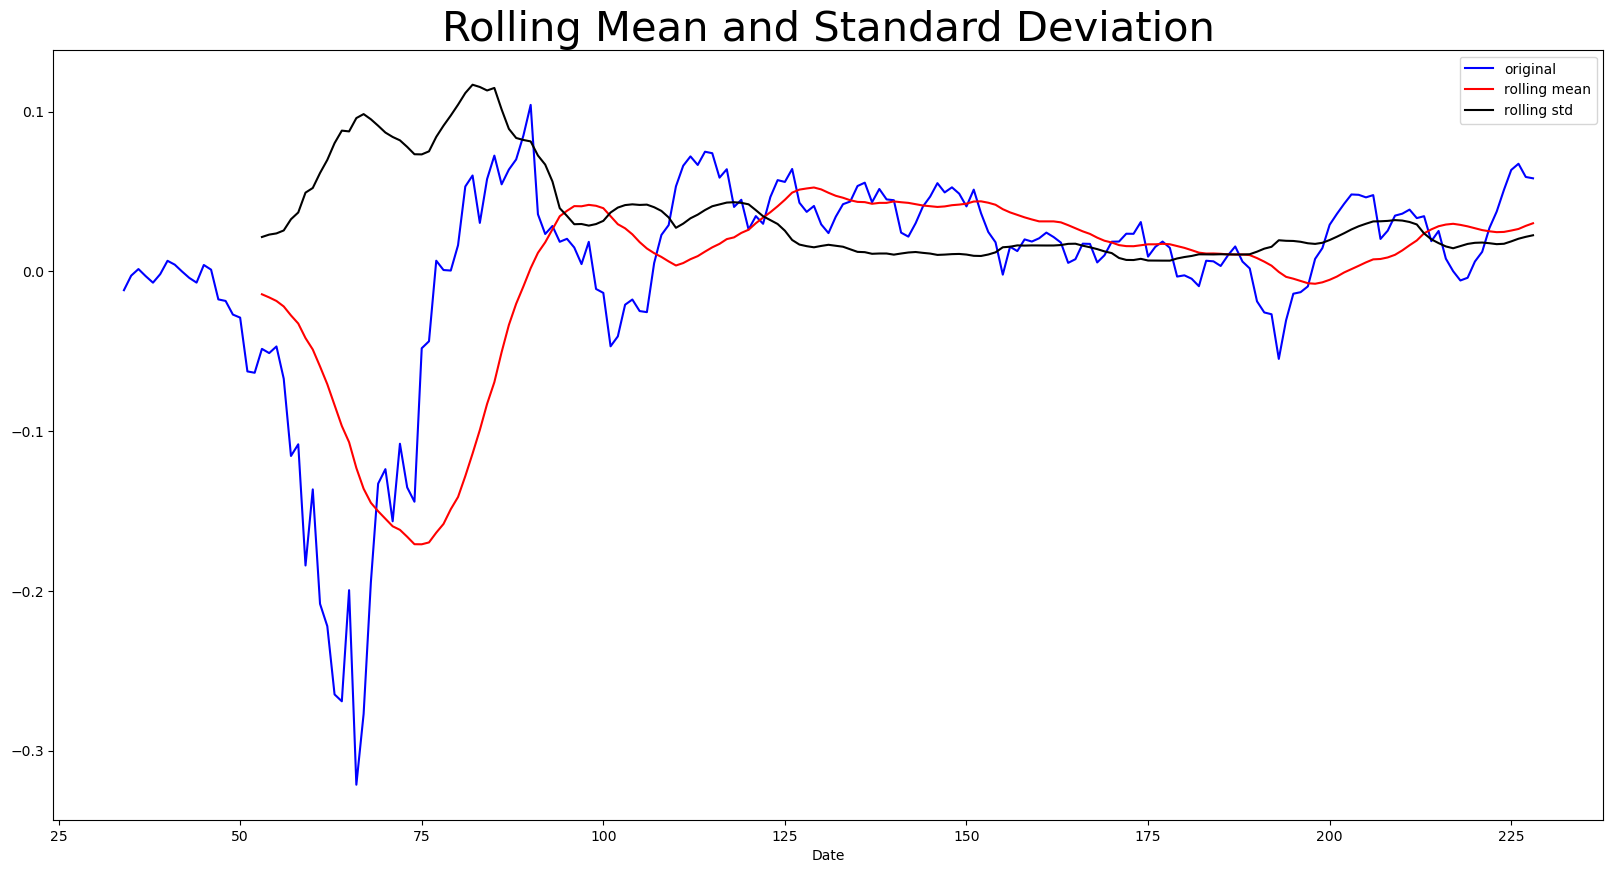

In [77]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [65]:
pip install pmdarima


     ---------------------------------------- 0.0/566.2 kB ? eta -:--:--
      --------------------------------------- 10.2/566.2 kB ? eta -:--:--
      --------------------------------------- 10.2/566.2 kB ? eta -:--:--
     ---- -------------------------------- 61.4/566.2 kB 409.6 kB/s eta 0:00:02
     ---- -------------------------------- 71.7/566.2 kB 393.8 kB/s eta 0:00:02
     ------- ---------------------------- 112.6/566.2 kB 469.7 kB/s eta 0:00:01
     ------- ---------------------------- 122.9/566.2 kB 400.9 kB/s eta 0:00:02
     ----------- ------------------------ 174.1/566.2 kB 499.5 kB/s eta 0:00:01
     ------------ ----------------------- 194.6/566.2 kB 491.5 kB/s eta 0:00:01
     -------------- --------------------- 235.5/566.2 kB 535.1 kB/s eta 0:00:01
     ---------------- ------------------- 256.0/566.2 kB 542.5 kB/s eta 0:00:01
     ----------------- ------------------ 276.5/566.2 kB 517.0 kB/s eta 0:00:01
     ------------------- ---------------- 307.2/566.2 kB 5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [66]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

In [78]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1229.189, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1228.630, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1231.551, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1230.976, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1230.477, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1230.063, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1229.768, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1232.322, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1228.479, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1233.521, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1230.635, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1233.470, Time=0.55 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1231.040, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1233.151, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0

Text(0, 0.5, 'Actual Stock Price')

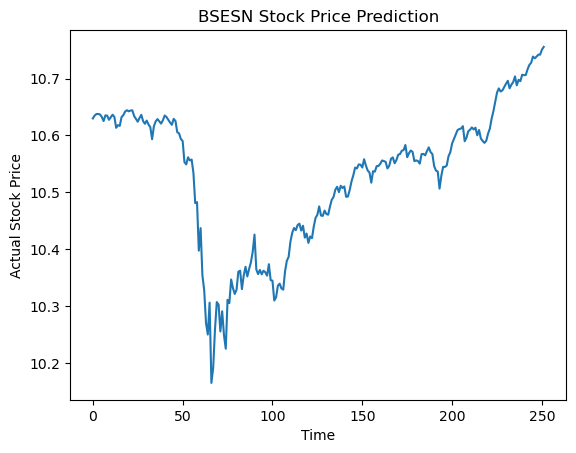

In [79]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

## Error Calculation

In [82]:
print("Shape of test_log:", test_log.shape)
print("Shape of predictions:", predictions.shape)

Shape of test_log: (0,)
Shape of predictions: (0, 1)


In [80]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.